# Building a credit derivatives compressor Open AI Gym environment

For my UROP project for the spring 2018 semester, I have created an Open AI Gym environment in an attempt to open the door for open source the problem of using reinforcement learning to build an automatic agent that finds the optimal methodology for compressing a set of derivatives contracts between groups of banks. Given the recent resurgence of financial regulation incentivizing actors within the financial sector to minimize their excess derivative contract notional, devising an artificial intellegence system to automatically minimize this excess over time is certainly a worthwhile endevour.

## Problem Statement

Perhaps I should define the problem I intend to solve, before providing information about the artificial intelligence mechanisms I used to achieve a solution. In this notebook, I attempt to build an OpenAI Gym (a standard format for testing and evaluatiing reinforcement agents' attempts at various problems) that can be used to test a reinforcement learning agent which aims to solve the following problem:

First we must define the following notation, a derivatives market can be modelled as consistenting the following elements:

1. A set of banks $B$ comprised of banks $(b_0,b_1,\dots b_n)$
1. A set of timesteps $T = (0,1,2,3,4,5,\dots,n)$, each timestep $t$ represents a week during which derivatives trading occurs.
1. A set of edges that comprise a directed graph G, $E = (e_0,e_1, \dots e_n)$ each edge $e_k =(b_i,b_j)$ of weight $w$ represents an debt owed of $w$ million dollars from bank $b_i$ to bank $b_j$.
1. An "arrival" of an edge is defined as one of two events:
    1. The origination of an edge $e_k =(b_i,b_j)$ that did not exist in prior timesteps.
    1. The increase of the weight $w$ of an edge $e_k$ that had existed in prior timesteps.
1. The total notional of a derivatives contract graph $G$ is equivalent to:
$$\sum_{\forall i,j \in |B|} w(b_i,b_j)$$

Where $w(b_i,b_j)$ is a function that returns the weight $w$ of the edge defined as a derivative contract relationship between bank $i$ and bank $j$.

Minimizing total notional at a given timestep $t$ is a solved problem, a paper that discusses the impact of solving this problem (derivatives portfolio compression) can be found [here](https://poseidon01.ssrn.com/delivery.php?ID=173022101119066104069084024124124064057072038035075028088075127101004122006005024111124122127028018042026073119104019029013097060013004075058101117086083074115000080085079001122091083005103114006027025067087001080089110082065023117022074089030116069073&EXT=pdf).

The precise problem that a intend to allow a reinforcement agent to learn how to solve is this:

If edges (derivative contracts) that arrive between banks due to a pattern determined by banks within a given financial system, can an agent to learn minimize notional excess over all periods? In math, this can be formalized as solving for:

$$\min_{t \in T} \sum_{\forall i,j \in |B|} w_t(b_i,b_j)$$

Where $w_t(b_i,b_j)$ is a function that returns the weight $w_t$ of the edge defined as a derivative contract relationship between bank $i$ and bank $j$ at timestep $t$.

## Reinforcement Learning Problem

The corresponding reinforcement learning problem is very similar to that problem statement above, but with a few simplifications. They are outlined below:

1. We will only be attempting to solve for the minimum amongst the top 5 most connected nodes, based on initial analysis, one can see that there are very few very connected nodes, so this is a fair simplification for the more general problem. A histogram is shown below:

1. For the early stages of this project, we will only aim to keep total notional below a certain percentage of what I define as counterfactual total notional, which is the total notional that would be observed given no action on a derivatives contract graph $G$, as of right now, this percentage of notional is set at 75%

1. To address computational hurdles, all contract originations are normalized by the largest edge that originates during the analyzed time period.

In [13]:
 #!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Reads total credit data
"""

# core modules
from os import walk
import pandas as pd
import numpy as np
import datetime as dt
import calendar
import networkx as nx
from operator import itemgetter
import random
import matplotlib.pyplot as plt

def load_data_to_adj_matrices(path,enddate):
    #Loads data from path into dictionary of weeks which map to adjacency matrices representing contracts that originated that week
    #Returns week_adj_matrices
    derivatives_df = pd.read_csv(path)
    derivatives_df = derivatives_df[derivatives_df.Duration != "ON"]
    derivatives_df = derivatives_df[derivatives_df.Market != "Market"]
    day_dataframes = dict()
    for _,row in derivatives_df.iterrows():
        if row.Date in day_dataframes.keys():
            day_dataframes[row.Date] = pd.concat([day_dataframes[row.Date],row],axis = 1)
        else:
            day_dataframes[row.Date] = pd.DataFrame(row)
        if row.Date == enddate:
            break
    BanksList = np.sort(pd.concat([derivatives_df["Aggressor"],derivatives_df["Quoter"]]).unique())
    numbanks = len(BanksList)
    day_adj_matrices = dict()
    week_edges = dict()
    week_adj_matrices = dict() 
    #Initialize array of zeroes for every date
    for date in day_dataframes.keys():
        day_adj_matrices[date] = np.zeros((numbanks,numbanks))
    for endweek in list(day_dataframes.keys())[0:-1:5]:
        week_adj_matrices[endweek] = np.zeros((numbanks,numbanks))
        week_edges[endweek] = []
    for d_i,date in enumerate(day_dataframes.keys()):
        if d_i // 5 >= len(list(week_adj_matrices.keys())):
            break
        endweek = list(week_adj_matrices.keys())[d_i // 5]
        
        endweekobj = dt.datetime.strptime(endweek, "%Y-%m-%d")
        for i in day_dataframes[date]:
            row = day_dataframes[date][i]
            #If the agressor is the lender
            a_idx = np.where(BanksList == row.Aggressor)[0][0]
            q_idx = np.where(BanksList == row.Quoter)[0][0]
            #Check to see if originating contract will not be removed soon
            dateobj = dt.datetime.strptime(date, "%Y-%m-%d")
            
            if (row.Duration == 'TN' or row.Duration == 'TNL') and dateobj + dt.timedelta(days = 2) <= endweekobj:
                continue
            if (row.Duration == 'SN' or row.Duration == 'SNL') and dateobj + dt.timedelta(days = 3) <= endweekobj:
                continue
            #If the agressor is the lender
            if row.Verb == "Sell":
                #create incidence matrix as well
                week_adj_matrices[endweek][q_idx,a_idx] = np.add(float(day_adj_matrices[date][q_idx,a_idx]),int(float(row.Amount)))
            #If the agressor is the borrower
            if row.Verb == "Buy":
                week_adj_matrices[endweek][a_idx,q_idx] = np.add(float(day_adj_matrices[date][a_idx,q_idx]),int(float(row.Amount)))
    return week_adj_matrices,numbanks

def find_most_connected(week_adj_matrices,n_banks):
    total_adj_matrix = week_adj_matrices[list(week_adj_matrices.keys())[0]]
    for week in list(week_adj_matrices.keys()):
        total_adj_matrix += week_adj_matrices[week]

    total_contracts = nx.DiGraph()
    for i in range(n_banks):
        for j in range(n_banks):
            if total_adj_matrix[i,j] != 0:
                total_contracts.add_edge(i,j,weight=total_adj_matrix[i,j])
    deg_centrality_dict = nx.degree_centrality(total_contracts)
    return list(deg_centrality_dict.values())



c:\python36\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


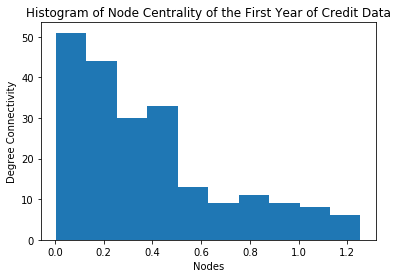

In [14]:
week_adj_matrices_all,n = load_data_to_adj_matrices('C:\Python36\Lib\site-packages\gym\envs\gym_compressor\complete_credit_data.csv','2000-01-05')
plt.hist(find_most_connected(week_adj_matrices_all,n))
plt.xlabel('Nodes')
plt.ylabel('Degree Connectivity')
plt.title('Histogram of Node Centrality of the First Year of Credit Data')
plt.show()

## Reward Structure

The reward structure of this problem is quite simple, our agent will recieve a reward of $-1$ for every time step it spends with total notional above the given threshold and positive 1 otherwise. Below is the "\_get\_reward" fucntion in our OpenAi Gym environment.

In [15]:
def _get_reward(self):
        """Reward is given for each timestep below the is_compressed threshold."""
        if self.is_compressed:
            return 1
        else:
            return -1

## Action Structure

As previously mentioned, minimizing the total notional amongst a set of banks $B$ and their respective edges $E$ while maintaining the amount owed from each bank to every other is a solved problem. It can be solved using the following linear programming problem:

\begin{equation} \label{eq1}
\begin{split}
\text{minimize } & \hat{u} \cdot e' \\
\text{subject to } & Qe' = v \\
& 0 \leq e' \leq e
\end{split}
\end{equation}

Where $\hat{u}$ is a vector of all 1's $e'$ is the set of edges that would minimize total notional $Q$ is an incidence matrix of our derivatives contract graph $G$ and $v$ is a vector representation of the total degree of each bank (which represents underlying value on each banks balance sheet).

## Observation Structure

### State Observations

The observation structure is a bit more complicated, the agent observes the state it exists in which is the culmination of action its taken, and contracts that have arrived during during the current episode. After it make a specific action, the agent sees an adjacency matrix repesenting derivatives contracts that have originated up to timestep $t$ between the top $n$ banks with the highest node centrality. As an adjacency matrix is a very noisy way to view and try to discern patterns within a derivatives contract graph, I have looked quite seriously into using the first $k$ singular values of the adjacency matrix to derive a rank $k$ representation of the adjacency matrix.

### Action Observations

In addition, the agent observes the critical cycles of the adjacency matrix representing the culmination of derivatives contracts up to timestep $t$, these critical cycles are calculated by utilizing a conservative compression linear programming algorithm to find the graph that minimizes the notional excess of our derivatives contract graph. I then subtract this graph from the "current adjacency matrix" as described in "State Observations". The cycles of this graph consist entirely of "critical cycles" or cycles that be removed in order to miniminze excess notional in the derivatives contract graph. Given $n$ critical cycles, our agent can choose between action $ 0 < i \leq n$ where choosing action $i$ runs the following algorithm, as described in (D’Errico and Roukny 2018):





In [17]:
def compress_critical_cycle(ccycle,adj_matrix):
    path = ccycle['cycle']
    path_edges = [(path[i-1],path[i]) for i in range(1,len(path))]
    min_edge = min([adj_matrix[edge] for edge in path_edges])
    for edge in path_edges:
        adj_matrix[edge] = adj_matrix[edge] - min_edge
    return adj_matrix

### Reward Observation

THe last observation to touch on is the observation that allows the agent to best discern how close it is to an optimal reward. Every timestep, our agent recieved information stating its excess\_percent which is the percent of counterfactual notional that is currently achieved by the current adjacency matrix. This is the same metric that will decide if an agent will recieve a reward of positive or negative 1 during a given timestep.

\_get\_state logic is displayed below

In [ ]:
    def _get_state(self):
        """Get the observation."""
        self.counterfactual_adj_matrix = self.counterfactual_adj_matrix + self.week_adj_matrices[self.curr_date]
        self.curr_adj_matrix = self.curr_adj_matrix + self.week_adj_matrices[self.curr_date]
        excess_percent = np.sum(self.curr_adj_matrix)/np.sum(self.counterfactual_adj_matrix)
        compress_res = compress_data(self.curr_adj_matrix)
        critical_matrix = compress_res["critical_matrix"]
        compressed_matrix = self.curr_adj_matrix - critical_matrix
        self.ccycles = critical_list_from_matrix(critical_matrix)
        return dict({"curr_adj_matrix":normalize_matrix(self.curr_adj_matrix),
                    "compressed_matrix":normalize_matrix(compressed_matrix),
                    "excess_percent":excess_percent})

## Next Steps
1. Build a deep learning agent to play in this model, right now the cross entropy agent from the OpenAI Gym package that I am using has quite poor performance; I made this gym enviroment to test architectures with stronger pattern recognition abilities, and I certainly would like to test my environment on such architectures.
1. I have been playing quite a bit with the idea of sending the reinforcement learning agent information about only portions of the singular value decompisition of the "current state adjacency matrix". This would help accentuate patterns within the adjacency matrix amongst banks with very distinct trading patterns. Once I am able to begin to work more seriously on using a deep learning architecture for policy discovery this will definitly be the first mutation of the very noisy adjacency matrix I will try.

In [11]:
from __future__ import print_function

import gym
from gym import wrappers, logger
import numpy as np
from six.moves import cPickle as pickle
import json, sys, os
from os import path
from _policies import BinaryActionLinearPolicy # Different file so it can be unpickled
import argparse

def cem(f, th_mean, batch_size, n_iter, elite_frac, initial_std=1.0):
    """
    Generic implementation of the cross-entropy method for maximizing a black-box function

    f: a function mapping from vector -> scalar
    th_mean: initial mean over input distribution
    batch_size: number of samples of theta to evaluate per batch
    n_iter: number of batches
    elite_frac: each batch, select this fraction of the top-performing samples
    initial_std: initial standard deviation over parameter vectors
    """
    n_elite = int(np.round(batch_size*elite_frac))
    th_std = np.ones_like(th_mean) * initial_std

    for _ in range(n_iter):
        ths = np.array([th_mean + dth for dth in  th_std[None,:]*np.random.randn(batch_size, th_mean.size)])
        ys = np.array([f(th) for th in ths])
        elite_inds = ys.argsort()[::-1][:n_elite]
        elite_ths = ths[elite_inds]
        th_mean = elite_ths.mean(axis=0)
        th_std = elite_ths.std(axis=0)
        yield {'ys' : ys, 'theta_mean' : th_mean, 'y_mean' : ys.mean()}

def do_rollout(agent, env, num_steps, render=False):
    total_rew = 0
    ob = env.reset()
    for t in range(num_steps):
        a = agent.act(ob)
        (ob, reward, done, _info) = env.step(a)
        total_rew += reward
        if render and t%3==0: env.render()
        if done: break
    return total_rew, t+1

if __name__ == '__main__':
    logger.set_level(logger.INFO)

    parser = argparse.ArgumentParser()
    parser.add_argument('--display', action='store_true')
    parser.add_argument('target', nargs="?", default="CartPole-v0")
    args = parser.parse_args()

    env = gym.make(args.target)
    env.seed(0)
    np.random.seed(0)
    params = dict(n_iter=10, batch_size=25, elite_frac = 0.2)
    num_steps = 200

    # You provide the directory to write to (can be an existing
    # directory, but can't contain previous monitor results. You can
    # also dump to a tempdir if you'd like: tempfile.mkdtemp().
    outdir = '/tmp/cem-agent-results'
    env = wrappers.Monitor(env, outdir, force=True)

    # Prepare snapshotting
    # ----------------------------------------
    def writefile(fname, s):
        with open(path.join(outdir, fname), 'w') as fh: fh.write(s)
    info = {}
    info['params'] = params
    info['argv'] = sys.argv
    info['env_id'] = env.spec.id
    # ------------------------------------------

    def noisy_evaluation(theta):
        agent = BinaryActionLinearPolicy(theta)
        rew, T = do_rollout(agent, env, num_steps)
        return rew

    # Train the agent, and snapshot each stage
    for (i, iterdata) in enumerate(
        cem(noisy_evaluation, np.zeros(env.observation_space.shape[0]+1), **params)):
        print('Iteration %2i. Episode mean reward: %7.3f'%(i, iterdata['y_mean']))
        agent = BinaryActionLinearPolicy(iterdata['theta_mean'])
        if args.display: do_rollout(agent, env, 200, render=True)
        writefile('agent-%.4i.pkl'%i, str(pickle.dumps(agent, -1)))

    # Write out the env at the end so we store the parameters of this
    # environment.
    writefile('info.json', json.dumps(info))

    env.close()


ModuleNotFoundError: No module named '_policies'